#An example notebook showcasing Synergia simulations with IOTA

This notebook showcases some of the basic functionality provided by the IPython notebook environment for running simulations with Synergia. We make use of basic Synergia functions as well as our own scripts. This notebook, the associated scripts, and a host of other resources can be found at RadiaSoft's [Beamsim](https://github.com/radiasoft/beamsim) github repository: https://github.com/radiasoft/beamsim.

**Basic Simulation Parameters**

- IOTA v6.6 lattice with 1 integrable optics section
- Sextupole strengths set to zero
- Nonlinear element adapted from MADX script - comprised of 20 discrete multipoles
- Full CHEF propagation - symplectic single particle tracking including nonlinear effects
- Each element in the lattice is sliced into 5 segments for computing dynamics.

**Basic Beam Parameters**

- 2.5 MeV proton beam
- No space charge or collective effects considered
- Beam is matched to a generalized KV distribution with normalized emittance $\epsilon_{N,x} = 0.3$ mm-mrad


##Imports and Setup

####IPython magics

In [1]:
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2

####Basic Python imports

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import tables
from mpi4py import MPI

####Synergia specific imports

In [3]:
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from base_diagnostics import lfplot
from base_diagnostics import latticework
from base_diagnostics import basic_calcs
from base_diagnostics import pltbunch
from base_diagnostics import elliptic_sp
from base_diagnostics import singleparticle
from base_diagnostics import options
from base_diagnostics import diagplot2
from elliptic import EllipticBeam6D
import synergia
import synergia_workflow

##Lattice imports from MADX files and visualization

Synergia supports lattice imports from MADX files, and can replicate a variety of magnetic elements, including the unique nonlinear elliptic magnets designed for the IOTA lattice.

In [4]:
#dictionary of lattices
lattices = {}
lattice_dir = '../lattices/Iota6-6/'

lattices['t1_1IO'] = '{}lattice_1IO.madx'.format(lattice_dir)
lattices['t1_2IO'] = '{}lattice_2IO.madx'.format(lattice_dir)
lattices['t2_1pair_min'] = '{}Chromaticity_Corrected/lattice_2IO_1s_approx.madx'.format(lattice_dir)
lattices['t2_2pair_min'] = '{}Chromaticity_Corrected/lattice_2IO_2s_min.madx'.format(lattice_dir)
lattices['t3_1pair_min_NLL'] = '{}Chromaticity_Corrected/lattice_2IO_1s_approx_NLL.madx'.format(lattice_dir)
lattices['t3_1IO_NLL'] = '{}lattice_1IO_nll_center.madx'.format(lattice_dir)
lattices['t3_2IO_NLL'] = '{}lattice_2IO_nll_center.madx'.format(lattice_dir)


name = 't3_1IO_NLL'

lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices[name])


for elem in lattice.get_elements():
    if elem.get_type() == 'nllens':
        elem.set_string_attribute("extractor_type", "chef_propagate")
        
nsteps_per_element = 5
nsteps = len(lattice.get_elements())*nsteps_per_element
        
order = 1
outputdir = 'example_run'

opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
opts.macro_particles=10000
#opts.emitx = 1.0e-5
workflow.make_path(outputdir)

stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

#construct bare lattice for comparison
bare_lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices['t1_1IO'])
bare_stepper = synergia.simulation.Independent_stepper_elements(bare_lattice, opts.map_order, opts.steps_per_element)
bare_lattice_simulator = bare_stepper.get_lattice_simulator()

###Plot the bare lattice functions

The Tier 1 (bare) IOTA lattice is completely symmetric, with equal tunes in x and y. The drift regions designed to accomodate the nonlinear element feature zero dispersion and a fixed "tune" advance of $\mu_x = \mu_y = 0.3 $.

/Users/ncook/.virtualenvs/scienceenv/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


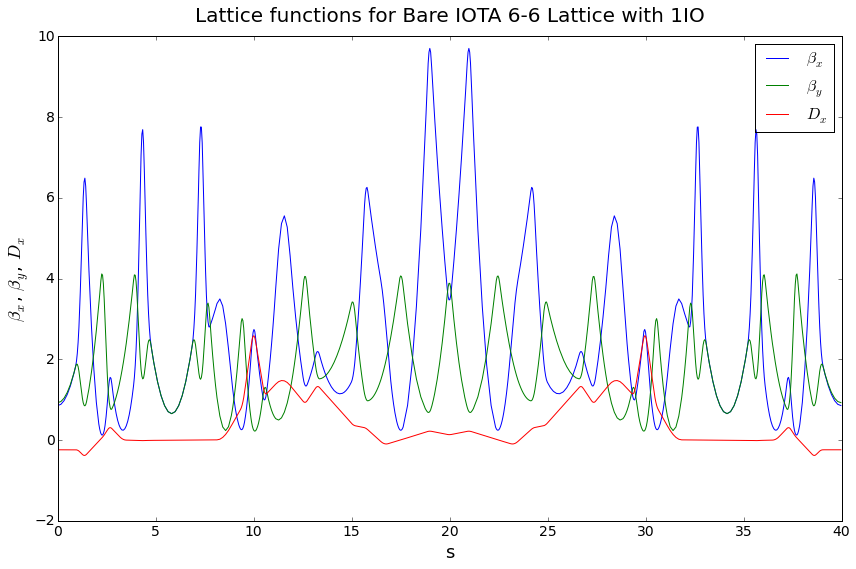

In [5]:
opts.lattice_name = 'Bare IOTA 6-6 Lattice with 1IO'
opts.ID = None
opts.path = None
opts.turns = opts.turns 
opts.variance = 0.5
opts.lattice_simulator = bare_lattice_simulator
opts.relpath = opts.output_dir
opts.lf_fns = ['beta_x','beta_y','D_x']
opts.lattice = bare_lattice
opts.save = False
opts.scale = 2

lfplot.plot_sliced_lattice_functions(opts)

###Plot the lattice functions with the NL element included

Inclusion of the nonlinear element breaks the symmetry of the lattice, adjusting the lattice tunes but maintaining individual symmetry in x and y through the nonlinear element, along with the zero dispersion requirement.

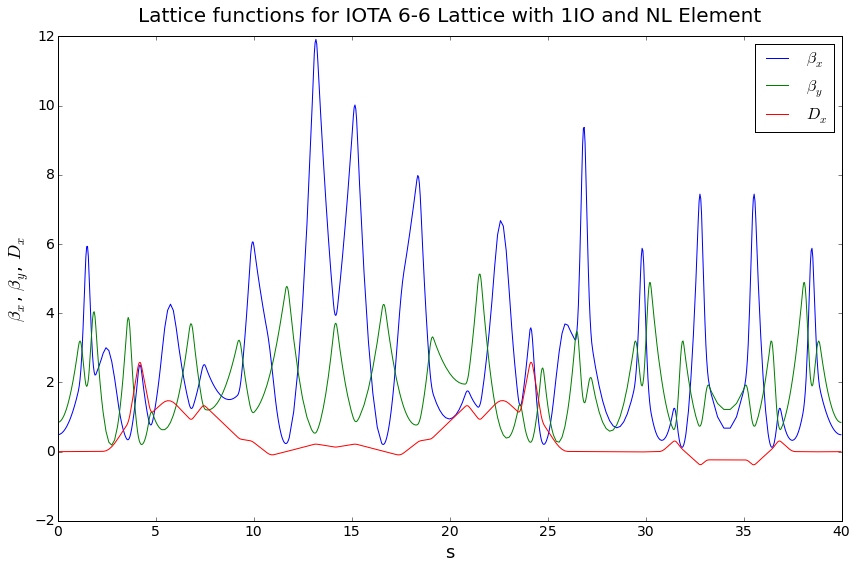

In [6]:
opts.lattice_name = 'IOTA 6-6 Lattice with 1IO and NL Element'
opts.ID = None
opts.path = None
opts.turns = opts.turns 
opts.variance = 0.5
opts.lattice_simulator = lattice_simulator
opts.relpath = opts.output_dir
opts.lf_fns = ['beta_x','beta_y','D_x']
opts.lattice = lattice
opts.save = False
opts.scale = 2

lfplot.plot_sliced_lattice_functions(opts)

##Generate a matched bunch for the IOTA lattice

Synergia includes functions for generating matched bunches with Gaussian or K-V distributions for a given linear lattice.

####Gaussian Bunch matched to the bare lattice

/Users/ncook/.virtualenvs/scienceenv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


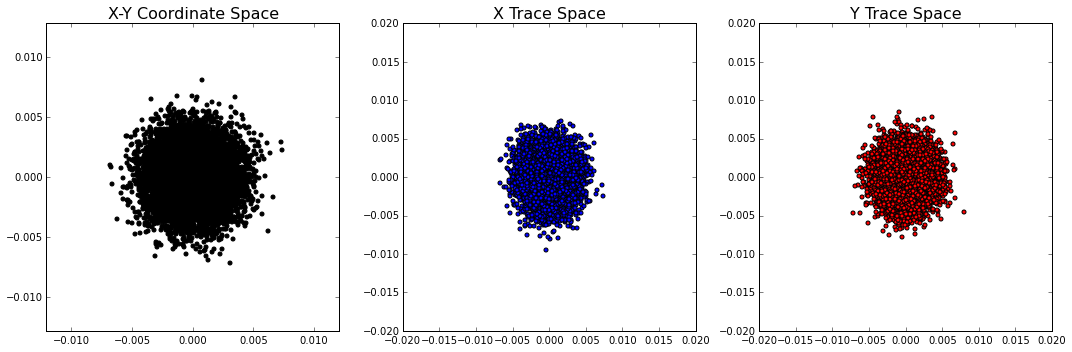

In [7]:
#get refence particle to find beta, gamma values
ref = lattice.get_reference_particle()
beta = ref.get_beta()
gamma = ref.get_gamma()

#We want the normalized emittance in x to be 0.3 mm-mrad
opts.norm_emittance = 0.3*1.e-6
opts.emitx = basic_calcs.get_geometric_emittance(opts.norm_emittance, beta, gamma)
opts.emity = opts.emitx

#Construct a matched bunch
myBunch = synergia.optics.generate_matched_bunch_transverse(
    bare_lattice_simulator, opts.emitx, opts.emity, opts.stdz, 
    opts.dpop, opts.real_particles, 
    opts.macro_particles, opts.seed) 

pltbunch.plot_bunch(myBunch)

####Generalized KV distribution matched to the IOTA lattice at the center of the NL element

For the nonlinear IOTA ring, a more complex matching is required. Stephen Webb has devised a matching procedure which cosntructs a generalized K-V distribution, with a fixed value of the 1st invariant, $H_0$. To produce the same normalized emittance of $\epsilon_{N,x} =0.3$ mm-mrad for the injected proton beam, we construct a bunch with fixed $H_0 = 9.74$ mm-mrad.

In [8]:
tval = 0.4 #elliptic strength parameter
cval = 0.01 #aperture parameter

opts.t = tval
opts.c = cval
opts.new_tune = 0.3
opts.lnll = 1.8
opts.nseg = 20
vals = basic_calcs.get_base_nll(opts.nseg, opts.lnll, opts.new_tune, opts.t, opts.c)

#specify vals for center of the section
opts.betae = vals[3]
opts.alphae = 0 #fixed 0 alpha for center
opts.beta0 = vals[3]

opts.emits = [9.74e-6]
opts.lattice = lattice

Constructed bunch with 10000 macroparticles, having mean H: 9.6170005061e-06 and std: 3.26405547044%
Loading Synergia particles from txt file:  example_run/myBunch.txt
Read  10000  particles


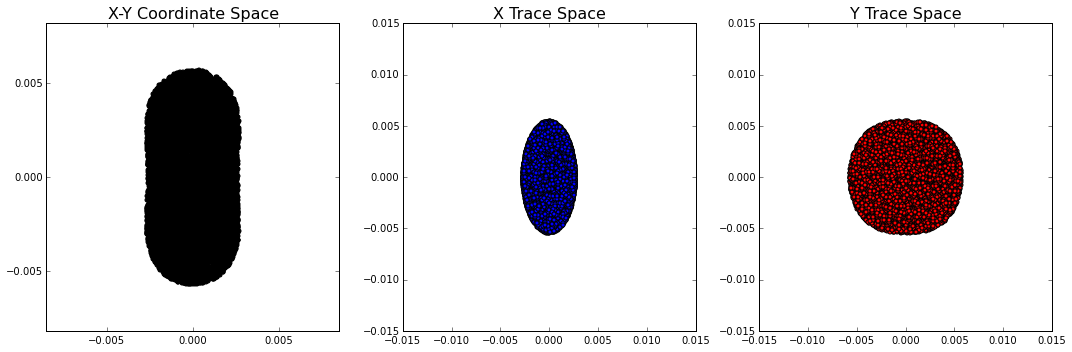

In [9]:
particles = EllipticBeam6D.toyEllipticalBeam6D(opts)

for index in range(len(opts.emits)):
    bunch = particles[index]
    initialH,initialI = elliptic_sp.calc_bunch_H(bunch,opts)
    bunch_mean = np.mean(initialH)
    bunch_std = np.std(initialH)
    bunch_var = (bunch_std/bunch_mean)*100
    print "Constructed bunch with {} macroparticles, having mean H: {} and std: {}%".format(opts.macro_particles, bunch_mean,bunch_var)
    #now add longitudinal momentum variation
    #For random samples with mean = 0, sigma = sigma, use sigma*np.random.randn(...)
    bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch))
    #bunch[:,5] = np.zeros(len(bunch)) #0 dpop

opts.num_total_particles = opts.macro_particles*len(opts.emits)
opts.tracked_particles = opts.num_total_particles

particles_file = '{}/myBunch.txt'.format(opts.output_dir)

np.savetxt(particles_file,bunch)         #write the bunch to a text file
bucket_length = beta*lattice.get_length()/4 #RF harmonic number is 4

comm = synergia.utils.Commxx(True) #define a communicator
myBunch = read_bunch.read_bunch(particles_file, ref, opts.real_particles, bucket_length, comm)

pltbunch.plot_bunch(myBunch)

##Perform a basic simulation

We will run our matched beam through the nonlinear lattice for 100 turns, outputing individual particle coordinates (`Diagnostics_particles`) each turn and basic RMS bunch properties (`Diagnostics_basic`) each step (slice) of the simulation.

In [10]:
#Construct the bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)
print "Saving basic diagnostics each step"

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)
print "Saving full2 diagnostics each turn"

#particle diagnostics - PER TURN
opts.turnsPerDiag = 1
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag, opts.turnsPerDiag)
print "Saving turn-by-turn particle data every {} turns".format(opts.turnsPerDiag)

opts.turns = 100
opts.checkpointperiod = 10
opts.maxturns = opts.turns+1

myrank = comm.get_rank()
print "setting up propagator for rank {}".format(myrank)
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)

print "starting simulation for rank {}".format(myrank)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

#clean up files
workflow.cleanup(opts.output_dir)

Saving basic diagnostics each step
Saving full2 diagnostics each turn
Saving turn-by-turn particle data every 1 turns
setting up propagator for rank 0
starting simulation for rank 0


##Basic Diagnostics

RMS beam properties are easily reconstructed from the basic diagnostics. Below, RMS bunch size in x and y, respectively, are overlayed for turn 1 and for turn 100.

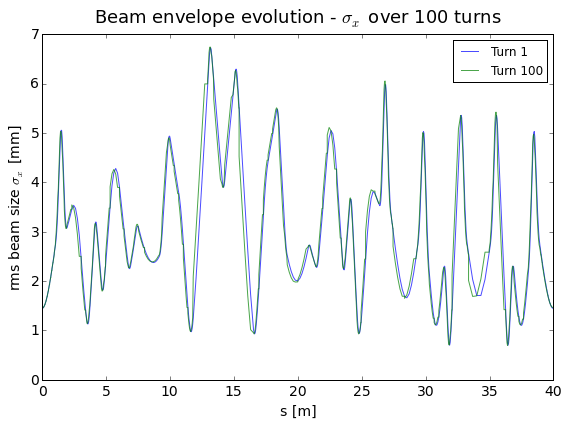

In [11]:
from base_diagnostics import diagplot2

opts.inputfile = opts.output_dir + '/basic.h5'
opts.plots = ['x_std', 'y_std']
plotVals = diagplot2.getPlotVals(opts.inputfile, opts.plots)

#define specific value arrays
xmaster = plotVals['s']
xstd = plotVals['x_std']
ystd = plotVals['y_std']

#we want to plot turn 0 and turn 100 on the same plot, so we should separate these specifically
interval = len(stepper.get_steps())
xstd_0 = xstd[:interval]
xstd_2 = xstd[1*interval:2*interval]
xstd_100 = xstd[-1*interval:] 

ystd_0 = ystd[:interval]
ystd_100 = ystd[-1*interval:] 

#We can use the same s value for each plot
sval_0 = xmaster[:interval]

fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(sval_0,xstd_0*1.e3,'b-',alpha=0.7, label='Turn 1') #plot the 1st turn
ax.plot(sval_0,xstd_100*1.e3,'g-',alpha=0.7, label='Turn 100') #plot the 1st turn
axtitle = "Beam envelope evolution - $\sigma_x$ over 100 turns"
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,lattice.get_length()])
ax.legend()
sv_title = '{}/RMS_x_1_100.pdf'.format(opts.output_dir)
fig.tight_layout()
fig.savefig(sv_title,bbox_inches='tight')

##Particle Diagnostics

Individual particles may be tracked, or alternatively their coordinates at specified positions in the ring may be dumped. Below, Poincare surfaces of sections are displayed for a handful of particles, illustration their motion in normalized coordinates.

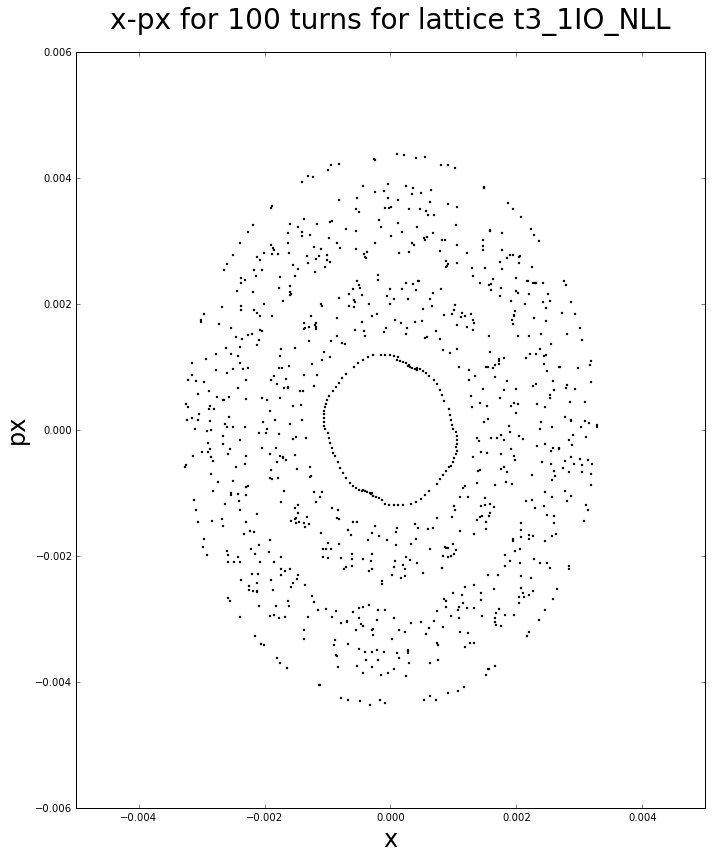

In [15]:
opts.lost = None
opts.plots = ['x','px']
opts.relpath = opts.output_dir
#opts.num = 100
opts.hcoord = opts.plots[0]
opts.vcoord = opts.plots[1]
opts.lattice_name = name
opts.scale = 2
opts.lattice = lattice
opts.save = True
opts.num = 10
opts.plot_lost = False
elliptic_sp.toy_plot_Poincare(opts)

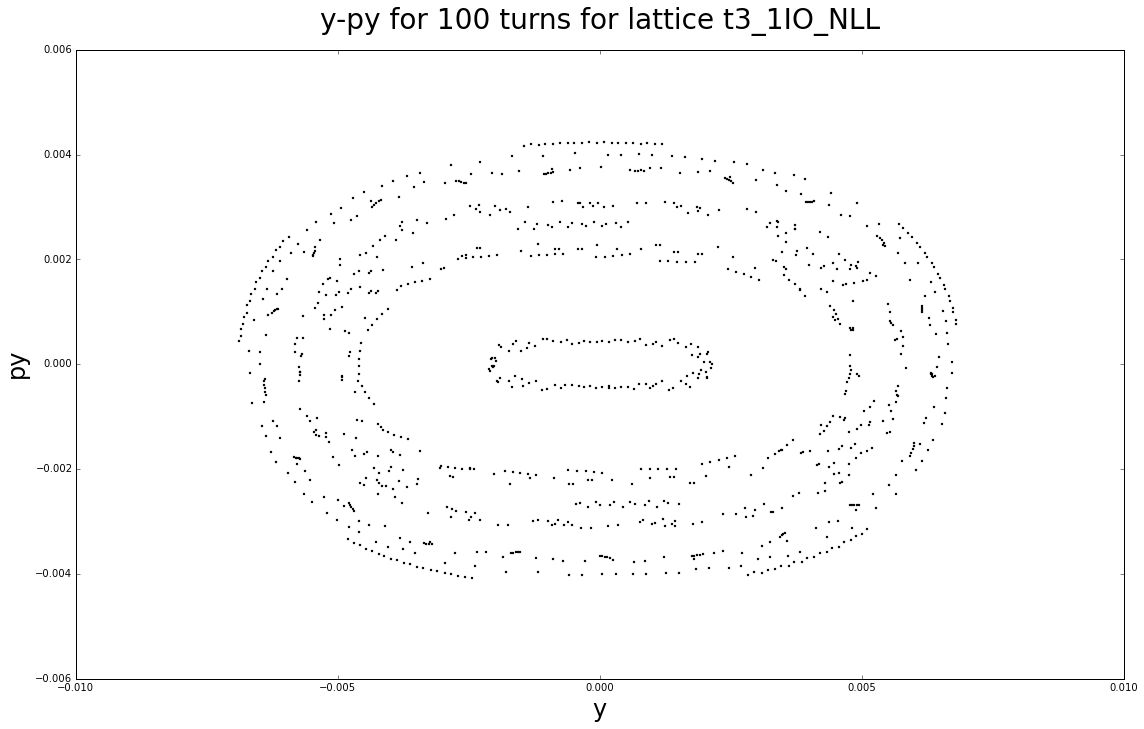

In [16]:
opts.lost = None
opts.plots = ['y','py']
opts.relpath = opts.output_dir
#opts.num = 100
opts.hcoord = opts.plots[0]
opts.vcoord = opts.plots[1]
opts.lattice_name = name
opts.scale = 2
opts.lattice = lattice
opts.save = True
opts.num = 10
opts.plot_lost = False
elliptic_sp.toy_plot_Poincare(opts)

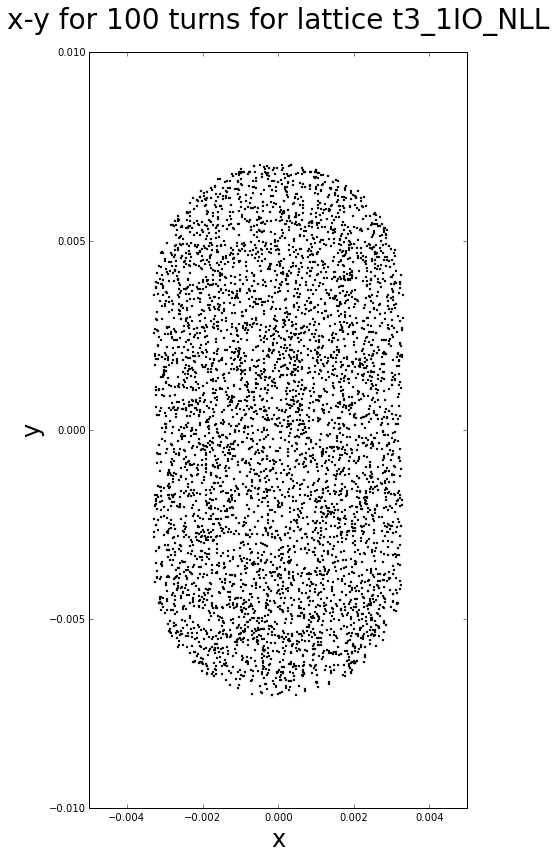

In [17]:
opts.lost = None
opts.plots = ['x','y']
opts.relpath = opts.output_dir
#opts.num = 100
opts.hcoord = opts.plots[0]
opts.vcoord = opts.plots[1]
opts.lattice_name = name
opts.scale = 2
opts.lattice = lattice
opts.save = True
opts.num = 50
opts.plot_lost = False
elliptic_sp.toy_plot_Poincare(opts)

##Bunch evolution

We can similarly plot the bunch at a given turn to look for instances of nonlinear effects driving particles to large amplitude.

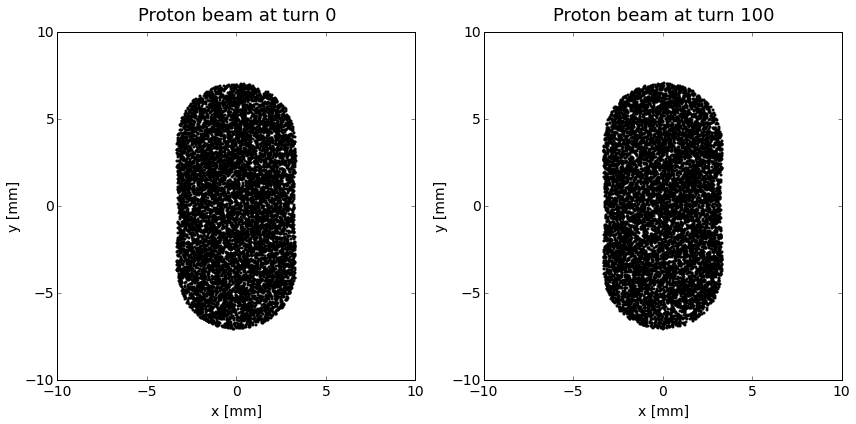

In [35]:
from matplotlib import gridspec

#Load particles
opts.relpath = opts.output_dir
turnnums = ['00','100']
filelist = ["particles_00{}.h5".format(val) for val in turnnums]
filelist[-1] = "particles_0100.h5" #force this one
path = os.path.join(os.getcwd(),opts.relpath)
pathlist = [os.path.join(path,fn) for fn in filelist]  #construct path list for files

#opts.relpath = opts.output_dir
#files = elliptic_sp.get_file_list(opts)
twiss = elliptic_sp.get_toy_twiss(opts)
#t2 = twiss[:-1,:]
#twiss = get_twiss(opts.lattice_simulator)
#lost = elliptic_sp.get_lost_particle_list(opts)

#hArray = []
#iArray = []
log = []    #log is an array for storing output text
part_array = []

for index,outfile in enumerate(pathlist):
    #print "Grabbing coordinates for file {}".format(index)
    
    header,particle_vals = elliptic_sp.get_particles(outfile)
    
    if index == 0:
        part_array = particle_vals
    else:
        part_array = np.vstack([part_array,particle_vals])
        
parts_0 = part_array[:10000]
parts_100 = part_array[10000:20000]


#Construct coordinates
header= {}
header['s_val'] = 0.
norm_coords0 = elliptic_sp.normalized_coordinates(header, parts_0, twiss)
x_c0 = norm_coords0[:,0]
px_c0 = norm_coords0[:,1]
y_c0 = norm_coords0[:,2]
py_c0 = norm_coords0[:,3]


header= {}
header['s_val'] = 0.
norm_coords100 = elliptic_sp.normalized_coordinates(header, parts_100, twiss)
x_c100 = norm_coords100[:,0]
px_c100 = norm_coords100[:,1]
y_c100 = norm_coords100[:,2]
py_c100 = norm_coords100[:,3]


#Make the plot
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 

ax0 = plt.subplot(gs[0])
ax0.scatter(1000*x_c0,1000*y_c0, s=4, c='k')
ax0.set_title('Proton beam at turn 0', y = 1.02, fontsize = 18)  
ax0.set_xlabel("x [mm]",fontsize=14)
ax0.set_ylabel("y [mm]",fontsize=14)
ax0.tick_params(axis='x', labelsize=14)
ax0.tick_params(axis='y', labelsize=14)
ax0.set_xlim([-10,10])
ax0.set_ylim([-10,10])

ax1 = plt.subplot(gs[1])
ax1.scatter(1000*x_c100,1000*y_c100, s=4, c='k')
ax1.set_title('Proton beam at turn 100', y = 1.02, fontsize = 18)  
ax1.set_xlabel("x [mm]",fontsize=14)
ax1.set_ylabel("y [mm]",fontsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])

sv_title = '{}/beam_0_100.pdf'.format(opts.output_dir)
fig.tight_layout()
fig.savefig(sv_title,bbox_inches='tight')
fig.show()